In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
df = pd.read_csv('nishati1000Wblanket.csv',header=1)
columns_to_remove = ['Riso (MOhm)', 'Viso (V)', 'Iclamp (Amp)', 'ac/dc']
df = df.drop(columns=columns_to_remove)
# df[:3]

In [3]:
df = df.assign(Index=df['Index'].replace('', np.nan))
df = df.dropna(subset=['Index'])
df

,Index,TestType,Rpe (Ohm),Voc (VDC),Isc (ADC),Irr (W/m2),Ta (C),Tpv (C),HH:MM:SS,DD/MM/YYYY,...,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47
0,1,16,NaN,15.8,7.649,860,NaN,26.5,1:39:13,3/2/2012,...,14.870:4.240:0:20:0:35860,15.145:3.218:0:21:0:35260,15.366:2.336:0:22:0:34660,15.507:1.648:0:23:0:34060,15.630:1.106:0:24:0:33460,15.688:0.707:0:25:0:32860,15.739:0.430:0:26:0:32260,15.810:0.000:0:29:0:2,0,9F89


In [4]:
ivcurve_index = df.columns.get_loc('IVCurve')
columns_after_ivcurve = df.columns[ivcurve_index:]
counter = 1
arr = []
for index, row in df.iterrows():
    vlist = []
    ilist = []
    plist = []
    
    
    for point in row[columns_after_ivcurve]:
        if point == 0:
            # print('hit')
            break
        else:
            points = point.split(':')
            # print(points)
            if len(points) == 1:
                # print('ERROR', points, point)
                break
            vlist.append(float(points[0]))
            ilist.append(float(points[1]))
            plist.append(float(points[0])*float(points[1]))

    

    counter += 1
    # print('row \n', row)
seriesvlist = []
parallelvlist = []
parallelilist = []
for i in range(len(plist)):
    plist[i] *= 8

    #series 8 * P, 1 * I, 8 * P
    seriesvlist.append(8 * vlist[i])

    #parallel 8 * P, 2 * I, 4 * P
    parallelvlist.append(4 * vlist[i])
    parallelilist.append(2 * ilist[i])



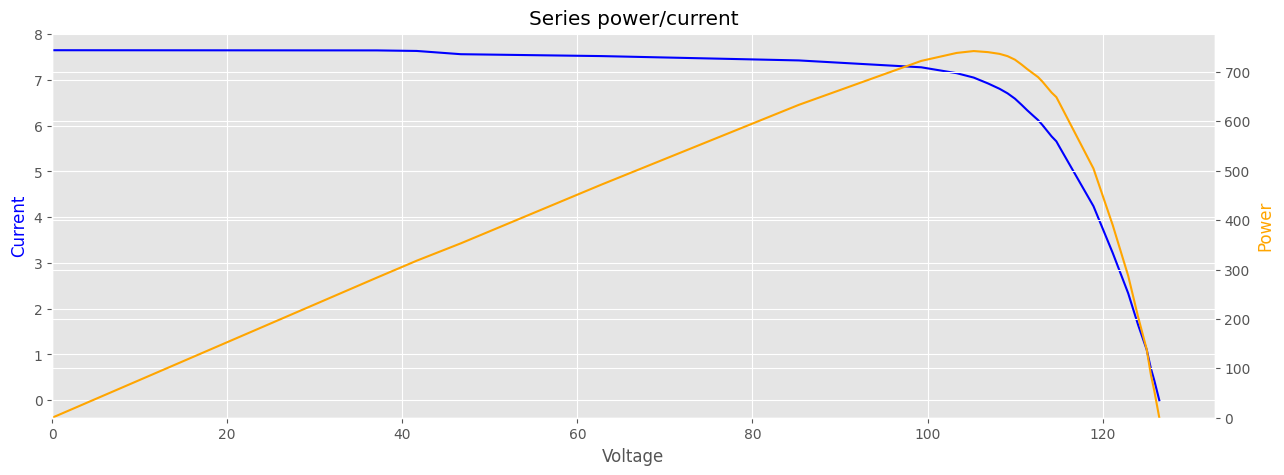

In [5]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
plt.title('Series power/current')
ax1.plot(seriesvlist, ilist, 'b-')
ax2.plot(seriesvlist, plist, '-',color='orange')

ax1.set_xlabel('Voltage')
ax1.set_ylabel('Current', color='b')
ax2.set_ylabel('Power', color='orange')

plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)


plt.show()

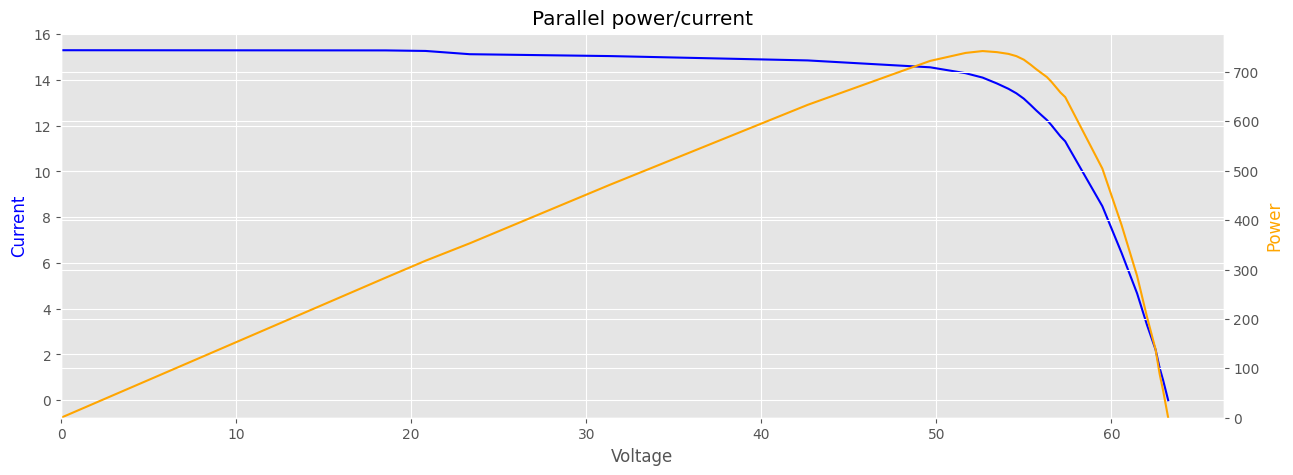

In [6]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
plt.title('Parallel power/current')
ax1.plot(parallelvlist, parallelilist, 'b-')
ax2.plot(parallelvlist, plist, '-',color='orange')

ax1.set_xlabel('Voltage')
ax1.set_ylabel('Current', color='b')
ax2.set_ylabel('Power', color='orange')
plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)

plt.show()

In [7]:
T = 30
IRR = 830
adjparallelvlist = []
adjseriesilist = []
adjplist = []
adjseriesvlist = []
adjparallelilist = []
for i in range(len(plist)):
    # Adjusting for Irradiance 
    adjparallelilist.append(parallelilist[i] * (1000/IRR))
    adjseriesilist.append(parallelilist[i] * (1000/IRR))
    adjplist.append(plist[i] * (1000/IRR))
    
for i in range(len(plist)): 
    # Talesun G1 Cell Specifications for Temp Changes
    adjplist[i] = adjplist[i] / (1 - (0.00374 * (T - 25)))
    adjseriesvlist.append(seriesvlist[i]/ (1 - (0.00275 * (T - 25))))
    adjparallelvlist.append(parallelvlist[i] / (1 - (0.00275 * (T - 25))))
    adjseriesilist[i] = (adjseriesilist[i] / (1 + (0.0003 * (T - 25))))


print(len(adjparallelvlist), len(adjseriesilist), len(adjplist), len(adjseriesvlist))

29 29 29 29


In [8]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y[np.argmax(y)]
    text= "Vmp={:.3f}, Pmp={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    # arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(1,1), **kw)

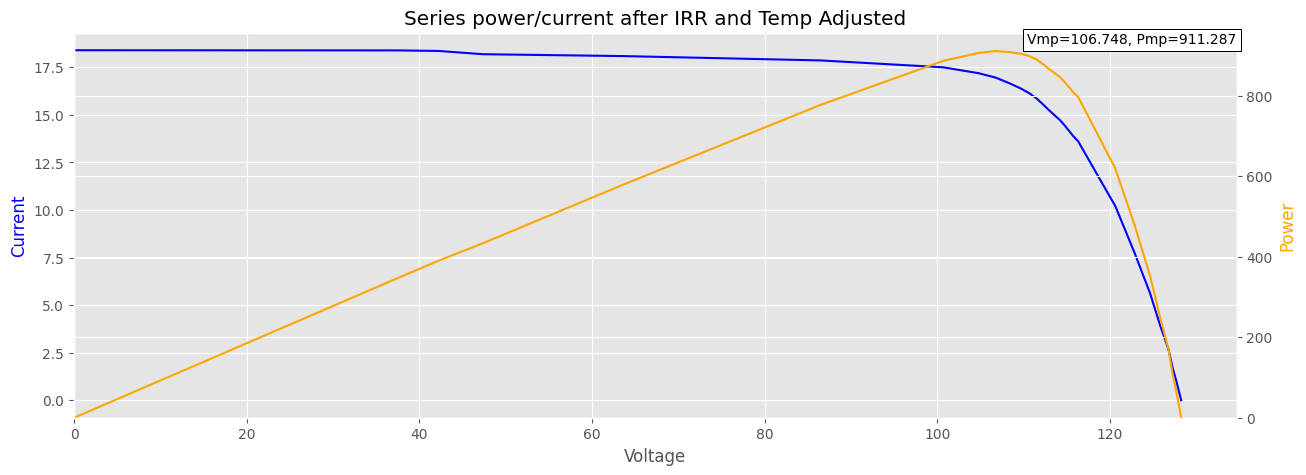

In [9]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
plt.title('Series power/current after IRR and Temp Adjusted')
ax1.plot(adjseriesvlist, adjseriesilist, 'b-')
ax2.plot(adjseriesvlist, adjplist, '-',color='orange')

ax1.set_xlabel('Voltage')
ax1.set_ylabel('Current', color='b')
ax2.set_ylabel('Power', color='orange')
annot_max(adjseriesvlist,adjplist)
plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)

plt.show()


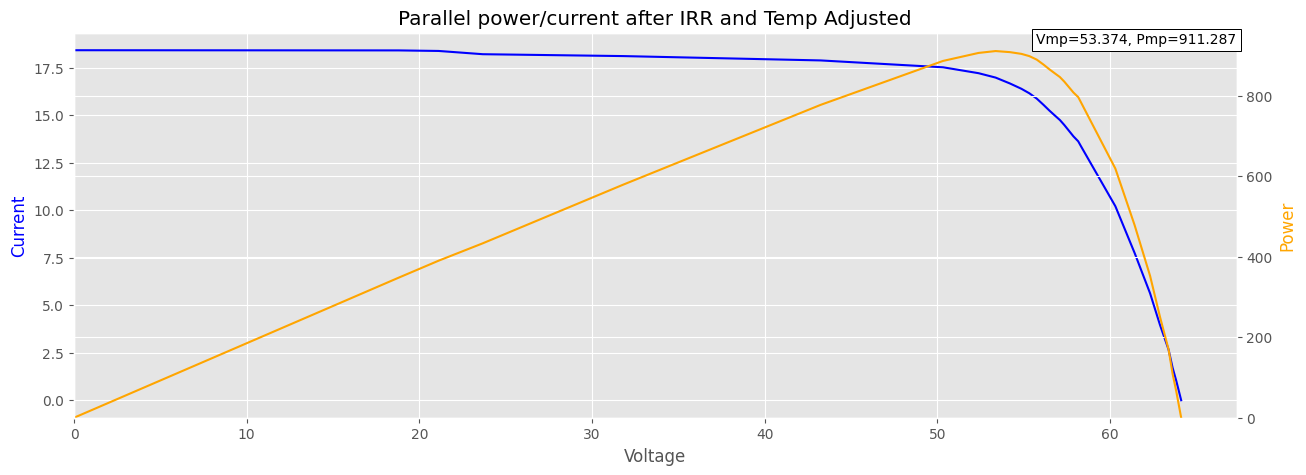

In [10]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
plt.title('Parallel power/current after IRR and Temp Adjusted')
ax1.plot(adjparallelvlist, adjparallelilist, 'b-')
ax2.plot(adjparallelvlist, adjplist, '-',color='orange')

ax1.set_xlabel('Voltage')
ax1.set_ylabel('Current', color='b')
ax2.set_ylabel('Power', color='orange')
annot_max(adjparallelvlist,adjplist)

plt.xlim(xmin=0.0)
plt.ylim(ymin=0.0)

plt.show()